In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-24 11:26:08.269554: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-24 11:26:08.354863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 11:26:08.354926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 11:26:08.359383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 11:26:08.377255: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-24 11:26:10.723937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 11:26:10.801857: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 11:26:10.802043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path) # only laser power and velocity
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

feats = np.load(feats_path)
print("feats shape: ", feats.shape) # feats shape:  (100, 2, 2, 2, 2, 2, 2, 2, 2, 2)


manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
feats shape:  (9587, 8)


In [3]:
# dimensions of MP are the index 1 and 2 of column in feat
dim_lh = feats[:, 1:3]

max_lh = dim_lh.max(axis=0)
# normalize dim_lh based on max value of each column
dim_lh = dim_lh / max_lh

dim_lh


array([[0.11637931, 0.13836478],
       [0.11206897, 0.1572327 ],
       [0.14224138, 0.13836478],
       ...,
       [0.87068966, 0.47798742],
       [0.87068966, 0.47798742],
       [0.85344828, 0.48427673]])

In [4]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
# expand the dimension of x to 4D
manta = np.expand_dims(manta, axis=3)
xiris = np.expand_dims(xiris, axis=3)
x = np.concatenate((manta, xiris), axis=3)
y = dim_lh
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (9587, 320, 320, 2)
y shape:  (9587, 2)


In [5]:


# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x_train shape:  (7669, 320, 320, 2)
y_train shape:  (7669, 2)
x_test shape:  (1918, 320, 320, 2)
y_test shape:  (1918, 2)


In [6]:
del manta, xiris, y, dim_lh, x

In [7]:
def build_simpleCNN_model(resolution, n_channels, n_classes):
    """
        Build a simple CNN model with 2 convolutional layers, 2 max pooling layers, 1 fully connected layer and 1 output layer.
        The model is built using the Keras functional API.
        The model is compiled with the Adam optimizer and the categorical cross entropy loss function.
    """
    
    # Define the input shape
    """ input_shape = Input(shape=(resolution, resolution, n_channels))
    x = Conv2D(16, (3, 3), activation='relu')(input_shape) # 32
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu')(x) # 64
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x) # 64
    x = MaxPooling2D(pool_size=(2, 2))(x) """
    inputs = Input(shape=(resolution, resolution, n_channels))

    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    #x = Dropout(0.5)(x)
    #x = Dense(256, activation='relu')(x)
    output_l = Dense(1, activation="linear", name="lenght")(x)
    output_h = Dense(1, activation="linear", name="height")(x)
    

    # Define the model with the specified input and outputs
    model = Model(inputs=inputs, outputs=[output_l, output_h])
    return model

In [8]:
# build model
resolution = X_test.shape[1]
n_channels = X_test.shape[3]
n_classes = y_test.shape[1]

battch_size = 32
epochs = 30
validation_split = 0.2
learning_rate = 0.0001

print("resolution: ", resolution)
print("n_channels: ", n_channels)
print("n_classes: ", n_classes)

# build model
model = build_simpleCNN_model(resolution, n_channels, n_classes)

# compile model
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse') #, metrics=['mse'])  # Using Mean Squared Error (mse) as the loss
# print model summary
model.summary()


# train model
history = model.fit(x=X_train,
                    y=[y_train[:, 0], y_train[:, 1]],
                    batch_size=battch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=validation_split)


resolution:  320
n_channels:  2
n_classes:  2


2024-01-24 11:26:31.220201: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 11:26:31.220635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 11:26:31.220819: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 318, 318, 16)         304       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 159, 159, 16)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 157, 157, 32)         4640      ['max_pooling2d[0][0]']   

2024-01-24 11:26:47.031041: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-24 11:26:47.243930: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-24 11:26:47.896331: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-24 11:26:48.600136: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd52cdc2890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 11:26:48.600215: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 11:26:48.629909: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706095608.876055 2279015 device_compiler.h:186] 

192/192 [==============================] - 17s 57ms/step - loss: 0.2629 - lenght_loss: 0.1967 - height_loss: 0.0662 - val_loss: 0.0016 - val_lenght_loss: 0.0011 - val_height_loss: 4.7535e-04
Epoch 2/30
192/192 [==============================] - 7s 34ms/step - loss: 9.4710e-04 - lenght_loss: 5.1360e-04 - height_loss: 4.3350e-04 - val_loss: 0.0018 - val_lenght_loss: 9.5937e-04 - val_height_loss: 8.2525e-04
Epoch 3/30
192/192 [==============================] - 7s 34ms/step - loss: 8.3373e-04 - lenght_loss: 3.9002e-04 - height_loss: 4.4371e-04 - val_loss: 0.0014 - val_lenght_loss: 3.8842e-04 - val_height_loss: 0.0010
Epoch 4/30
192/192 [==============================] - 7s 34ms/step - loss: 6.6463e-04 - lenght_loss: 2.9694e-04 - height_loss: 3.6769e-04 - val_loss: 0.0012 - val_lenght_loss: 8.6540e-04 - val_height_loss: 2.8923e-04
Epoch 5/30
192/192 [==============================] - 7s 34ms/step - loss: 5.7159e-04 - lenght_loss: 2.7056e-04 - height_loss: 3.0102e-04 - val_loss: 5.2537e-04 -

In [9]:
# save model
#model.save("simpleCNN_model.h5")

In [10]:
# evaluate model
score = model.evaluate(X_test, [y_test[:, 0], y_test[:, 1]], verbose=0)
print(score)

[0.00024974480038508773, 0.0001453996228519827, 0.00010434516298118979]


60/60 [==============================] - 1s 15ms/step
r2 score:  0.9972478640334155 0.990437810154806


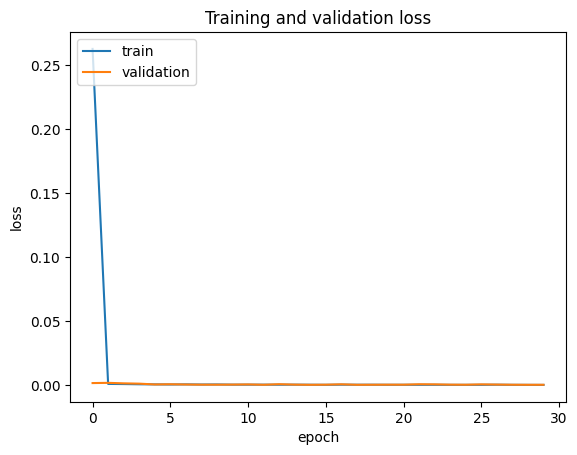

In [11]:
# eval regression model
from sklearn.metrics import r2_score

y_pred_l, y_pred_h = model.predict(X_test)
r2_l = r2_score(y_test[:,0], y_pred_l)
r2_h = r2_score(y_test[:,1], y_pred_h)
print("r2 score: ", r2_l, r2_h)

# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


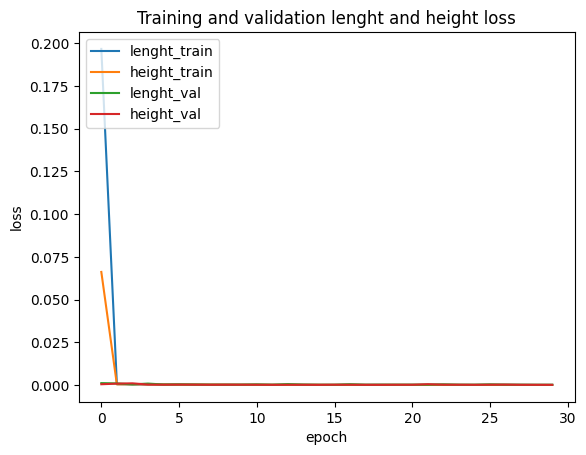

In [12]:
# plot lenght_loss and height_loss during training and validation
plt.plot(history.history['lenght_loss'])
plt.plot(history.history['height_loss'])
plt.plot(history.history['val_lenght_loss'])
plt.plot(history.history['val_height_loss'])
plt.title('Training and validation lenght and height loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['lenght_train', 'height_train', 'lenght_val', 'height_val'], loc='upper left')
plt.show()
 

In [13]:
# make a black image with the same shape as X_test[0]
black_image = np.zeros(X_test[0].shape[0])
print(black_image.shape)

# replace the second channel with the black image 
X_test_new = np.copy(X_test)
X_test_new[:, :, :, 1] = black_image

""" x = X_test_new[10]
# plot first and second channel of x
plt.imshow(x[:, :, 0])
plt.show()
plt.imshow(x[:, :, 1])
plt.show()
 """

(320,)


' x = X_test_new[10]\n# plot first and second channel of x\nplt.imshow(x[:, :, 0])\nplt.show()\nplt.imshow(x[:, :, 1])\nplt.show()\n '

60/60 [==============================] - 1s 14ms/step
r2 score:  -6.457392651662755 -14.643305083986544


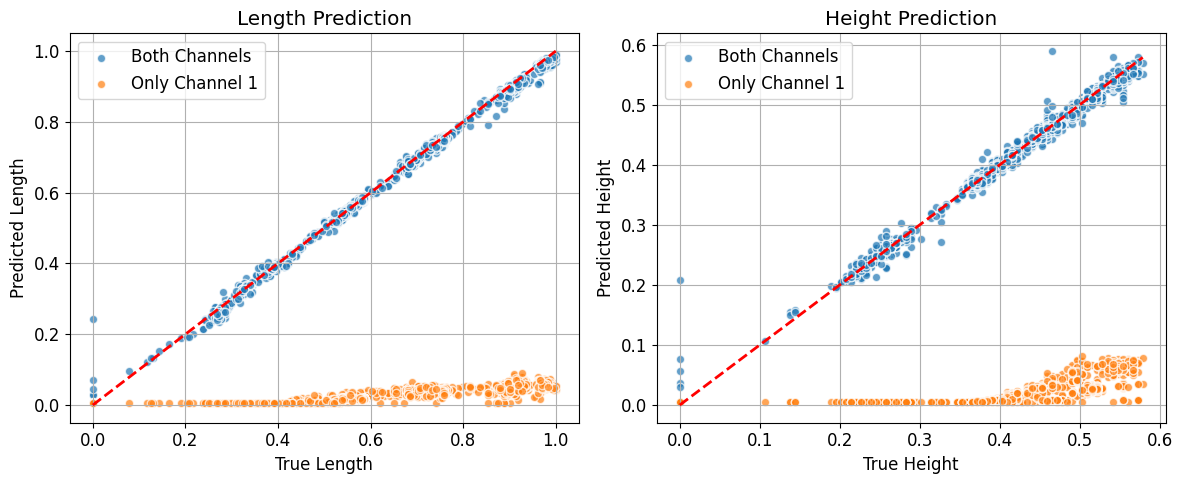

In [14]:
y_pred_l_new, y_pred_h_new = model.predict(X_test_new)
r2_l_new = r2_score(y_test[:,0], y_pred_l_new)
r2_h_new = r2_score(y_test[:,1], y_pred_h_new)

print("r2 score: ", r2_l_new, r2_h_new)

import matplotlib.pyplot as plt

# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 0], y_pred_l, alpha=0.7, edgecolors='w', label='Both Channels')
axs[0].scatter(y_test[:, 0], y_pred_l_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[0].plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 1], y_pred_h, alpha=0.7, edgecolors='w', label='Both Channels')
axs[1].scatter(y_test[:, 1], y_pred_h_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[1].plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



In [15]:
# instead of replacing the second channel with a black image, change the model to accept only one channel
# build model
resolution = X_test.shape[1]
n_channels = 1
n_classes = y_test.shape[1]

model_2 = build_simpleCNN_model(resolution, n_channels, n_classes)

# change the input shape of the model
#model_2.layers[0].input_shape = (None, resolution, resolution, n_channels)

In [16]:
# for all model layer print id, name and input shape
for layer in model.layers:
    print(layer.name, layer.input_shape)

input_1 [(None, 320, 320, 2)]
conv2d (None, 320, 320, 2)
max_pooling2d (None, 318, 318, 16)
conv2d_1 (None, 159, 159, 16)
max_pooling2d_1 (None, 157, 157, 32)
conv2d_2 (None, 78, 78, 32)
max_pooling2d_2 (None, 76, 76, 64)
flatten (None, 38, 38, 64)
dense (None, 92416)
lenght (None, 128)
height (None, 128)


In [17]:
# Helper function to adjust weights based on the number of input channels
def adjust_weights(weights_1, weights_2):
    # Determine the number of input channels in the source model
    input_channels_1 = weights_1[0].shape[2]
    
    # Determine the number of input channels in the target model
    input_channels_2 = weights_2[0].shape[2]

    # Adjust the weights based on the number of input channels
    adjusted_weights = [
        weights_1[0][:, :, :input_channels_2, :],
        weights_2[1]
    ]
    return adjusted_weights

# Transfer weights from model to model_2 for the first Conv2D layer
weights_1 = model.layers[1].get_weights()
weights_2 = model_2.layers[1].get_weights()
adjusted_weights = adjust_weights(weights_1, weights_2)
model_2.layers[1].set_weights(adjusted_weights)



In [18]:
# set the waights of the first layer of the model to the weights of the first layer of the previous model
layer_number = 20

for i, layer in enumerate(model_2.layers):

    # set weights untin layer_number

    if i>1 and i < layer_number+1:
        layer.set_weights(model.layers[i].get_weights())
        print("weights set, ", layer.name)
    else:
        print(i, layer.name)
        
    if i < layer_number:
        layer.trainable = False
        print("layer not trainable: ", layer.name)


0 input_2
layer not trainable:  input_2
1 conv2d_3
layer not trainable:  conv2d_3
weights set,  max_pooling2d_3
layer not trainable:  max_pooling2d_3
weights set,  conv2d_4
layer not trainable:  conv2d_4
weights set,  max_pooling2d_4
layer not trainable:  max_pooling2d_4
weights set,  conv2d_5
layer not trainable:  conv2d_5
weights set,  max_pooling2d_5
layer not trainable:  max_pooling2d_5
weights set,  flatten_1
layer not trainable:  flatten_1
weights set,  dense_1
layer not trainable:  dense_1
weights set,  lenght
layer not trainable:  lenght
weights set,  height
layer not trainable:  height


In [24]:
# compile model
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model_2.compile(optimizer=optimizer, loss='mse') #, metrics=['mse'])  # Using Mean Squared Error (mse) as the loss
# print model summary
model_2.summary()

# train model
history_2 = model_2.fit(x=X_train[:, :, :, 0],
                    y=[y_train[:, 0], y_train[:, 1]],
                    batch_size=battch_size,
                    epochs=20,
                    verbose=1,
                    validation_split=validation_split)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 318, 318, 16)         160       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 159, 159, 16)         0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 157, 157, 32)         4640      ['max_pooling2d_3[0][0]'

60/60 [==============================] - 1s 9ms/step
r2 score:  -6.2232280687630865 -14.050334507731458


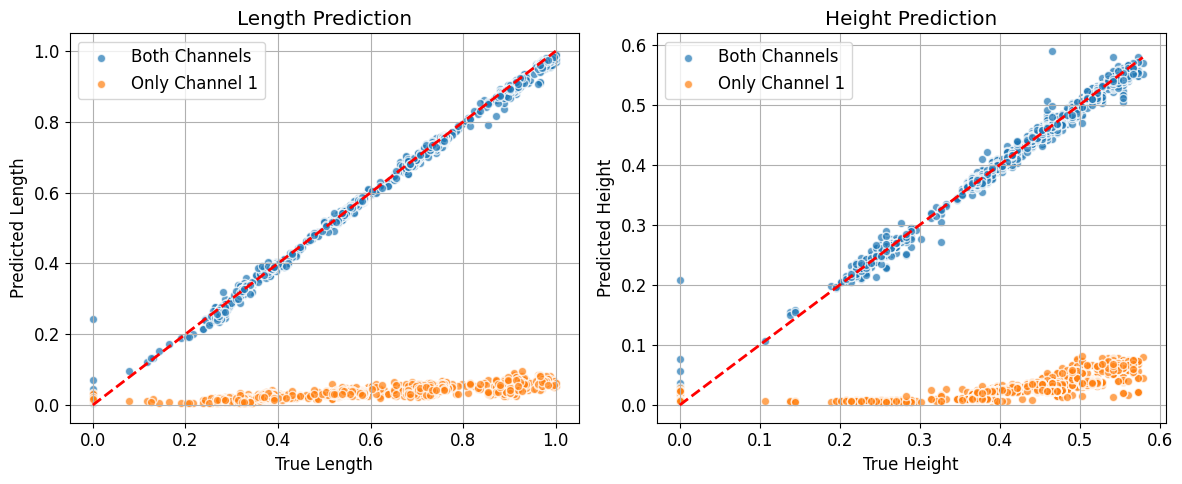

In [28]:
y_pred_l_new, y_pred_h_new = model_2.predict(X_test[:, :, :, 0])
r2_l_new = r2_score(y_test[:,0], y_pred_l_new)
r2_h_new = r2_score(y_test[:,1], y_pred_h_new)

print("r2 score: ", r2_l_new, r2_h_new)

import matplotlib.pyplot as plt

# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 0], y_pred_l, alpha=0.7, edgecolors='w', label='Both Channels')
axs[0].scatter(y_test[:, 0], y_pred_l_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[0].plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 1], y_pred_h, alpha=0.7, edgecolors='w', label='Both Channels')
axs[1].scatter(y_test[:, 1], y_pred_h_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[1].plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



Layer name: dense
60/60 [==============================] - 1s 13ms/step


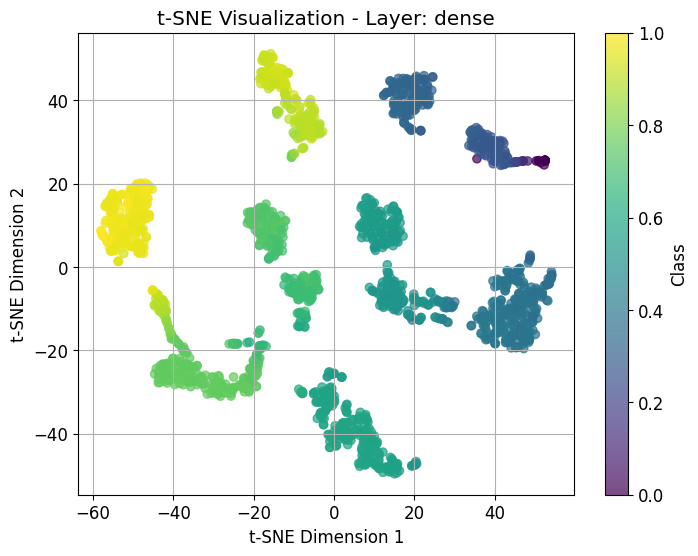

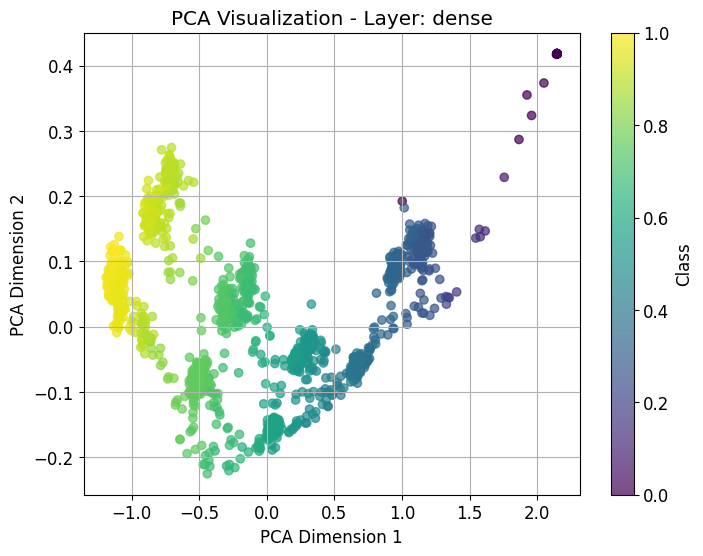

Layer name: dense
60/60 [==============================] - 1s 13ms/step


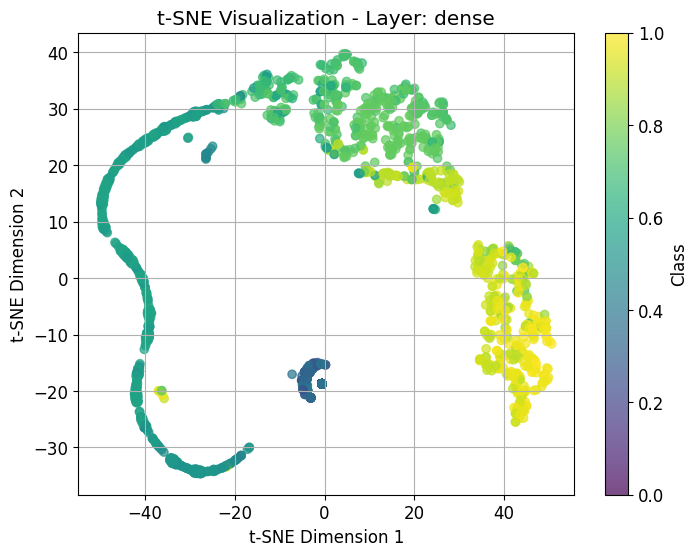

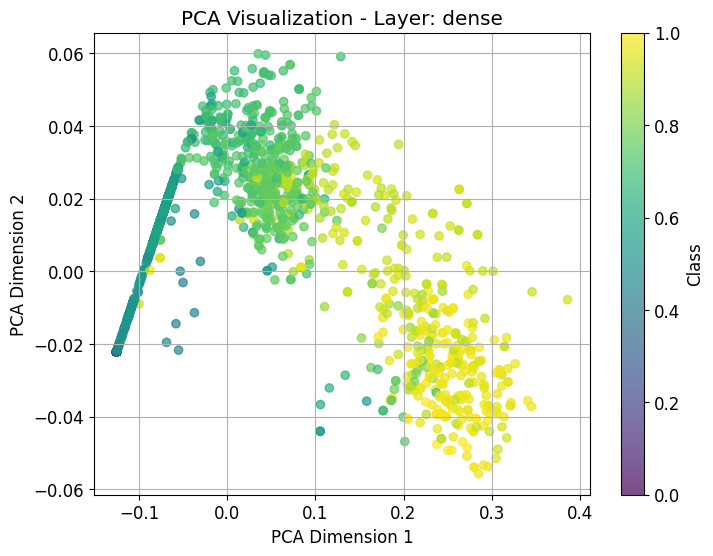

(array([[  1.2159472,  28.225054 ],
        [-38.944206 ,  -8.606329 ],
        [ -3.406493 , -15.528105 ],
        ...,
        [-17.15935  , -30.328947 ],
        [-42.23937  , -21.098774 ],
        [-39.149017 , -27.35909  ]], dtype=float32),
 array([[ 0.02497653,  0.02595456],
        [-0.07958393,  0.01132359],
        [-0.12571836, -0.02210183],
        ...,
        [-0.12499141, -0.02157515],
        [-0.08437215,  0.00785448],
        [-0.09203909,  0.00229959]], dtype=float32))

In [26]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

N_LAYER = -3

def eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):
    
    # Get intermediate layer output and print the name
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)
    layer_name = model.layers[n_layer].name
    print("Layer name:", layer_name)
    
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Visualization - Layer: {layer_name}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    # Apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='viridis', alpha=0.7)
        plt.title(f'PCA Visualization - Layer: {layer_name}')
        plt.xlabel('PCA Dimension 1')
        plt.ylabel('PCA Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    return tsne_results, pca_results

eval_tsne_pca(model, n_layer=N_LAYER, x_test=X_test, y_test=y_test, plot=True)

eval_tsne_pca(model, n_layer=N_LAYER, x_test=X_test_new, y_test=y_test, plot=True)

60/60 [==============================] - 1s 13ms/step


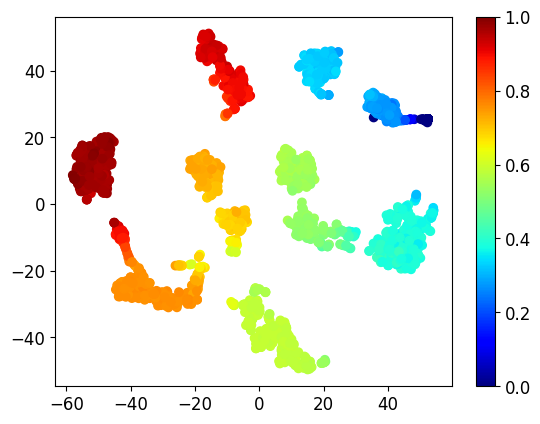

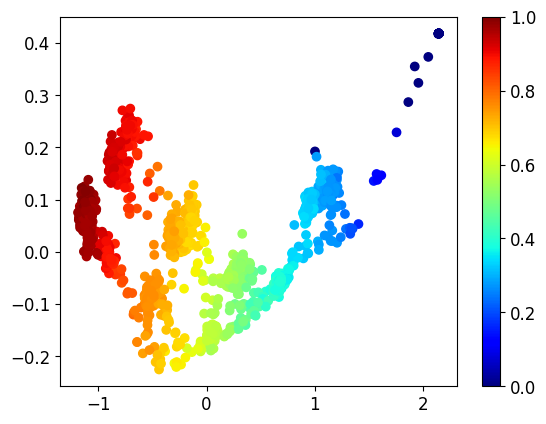

60/60 [==============================] - 1s 11ms/step


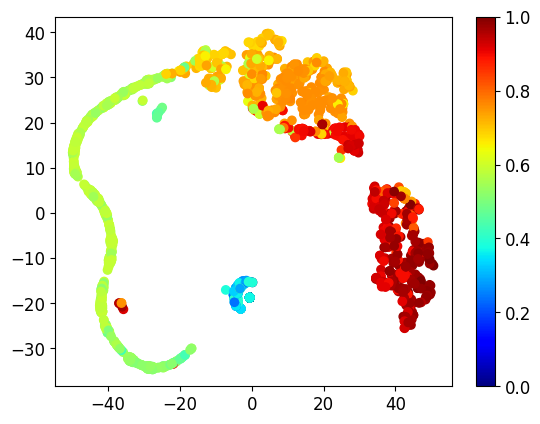

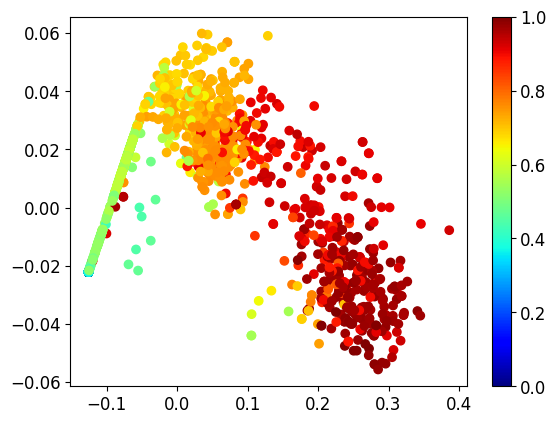

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def eval_tsne_pca(model, x_test, plot=True):
    # Assuming 'model' is your trained regression model and 'data' is your input data
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE or PCA
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    # apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='jet')
        plt.colorbar()
        plt.show()

    return tsne_results, pca_results

tsne_results, pca_results = eval_tsne_pca(model, X_test, plot=True)

# eval for X_test_new
tsne_results, pca_results = eval_tsne_pca(model, X_test_new, plot=True)

    